# Bouwen van House Price Predictor API  
De klant is geïnteresseerd in het voorspellen van huisprijzen, zodat het bedrijf kan gaan investeren. In plaats van een geregistreerde taxateur zoeken ze iets dat met de nieuwste technologie kan worden gedaan. De klant heeft wat gegevens verzameld over bestaande huizenprijzen van de afgelopen jaren en heeft gevraagd wat jullie kunnen doen. 



# 1. Importer Data en Afhankelijkheden installeren

In [1]:
!pip install pandas scikit-learn xgboost dill


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

In [3]:
#  Data laden
df = pd.read_csv('regressiondata.csv', index_col='ID')

In [4]:
df.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
0,2020.12,17.0,467.644775,4.0,5222.0,467104
1,2021.04,36.0,659.924963,3.0,5222.0,547714
2,2019.04,38.0,305.475941,7.0,5213.0,277232
3,2021.10,11.0,607.034754,5.0,5213.0,295958
4,2021.02,14.0,378.827222,5.0,5614.0,439963


In [5]:
df.tail()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
9351,2019.07,36.0,554.324820,3.0,5217.0,420246
9352,2021.02,21.0,2296.349397,4.0,5614.0,256087
9353,2020.11,18.0,856.174897,0.0,5614.0,257663
9354,2021.10,6.0,87.260667,9.0,5614.0,681072
9355,2020.12,20.0,584.007146,4.0,5614.0,403096


# 2. Split Data zodat we Snooping Bias voorkomen

Om Bias te voorkomen moeten we de dataset eerst opsplitsen. Anders is het risico dat je te veel jouw model bouwt op de specifieke data die je beschikbaar hebt (door vooroordelen over de dataset). Het is dus belangrijk om dit te doen voordat je EDA gaat toepassen op de dataset.

In [6]:
# importeren van split functie
from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(df, test_size=0.3, random_state=1234)

In [8]:
# checken van de grotes en waardes of het goed is gegaan
train.shape

(6549, 6)

In [9]:
test.shape

(2807, 6)

In [10]:
train.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8450,2021.02,34.0,460.994365,8.0,5614.0,460286
5758,2020.01,17.0,614.851833,3.0,5213.0,253332
4030,2021.06,34.0,285.892687,9.0,5614.0,486532
8447,2020.12,0.0,195.213314,6.0,5222.0,595168
4370,2019.03,34.0,124.082230,8.0,5212.0,250495


# 3. Exploratory Data Analysis (EDA)

## Globale EDA

In [11]:
# Data types
train.dtypes

TransactionDate      float64
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode             float64
HousePrice            object
dtype: object

Datatypes: 
- HouseAge moet geen float zijn. 
- PostCode moet een categorical type zijn.
- HousePrice is een string en moet een float zijn.

In [12]:
# Extra informatie, zoals null values
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6549 entries, 8450 to 8915
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionDate    6548 non-null   float64
 1   HouseAge           6546 non-null   float64
 2   DistanceToStation  6547 non-null   float64
 3   NumberOfPubs       6547 non-null   float64
 4   PostCode           6547 non-null   float64
 5   HousePrice         6544 non-null   object 
dtypes: float64(5), object(1)
memory usage: 358.1+ KB


In [13]:
# samenvatting van de statestieken
train.describe()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode
count,6548.000000,6546.000000,6547.000000,6.547000e+03,6547.000000
mean,2020.072389,17.375344,1091.759504,7.677828e+02,5294.499160
std,0.815922,11.469272,1270.038426,6.179430e+04,158.397718
min,2019.010000,0.000000,23.829424,0.000000e+00,5212.000000
25%,2019.100000,9.000000,268.649033,1.000000e+00,5213.000000
50%,2020.070000,15.000000,545.312168,4.000000e+00,5217.000000
75%,2021.040000,28.000000,1529.343484,6.000000e+00,5222.000000
max,2021.120000,43.000000,6486.256457,4.999999e+06,5614.000000


NumberOfPubs maximale waardes is heel hoog (waarschijnlijk een data error)

In [14]:
# Type cast de incorrecte datatypes naar de juiste datatypes
train['PostCode'] = train['PostCode'].astype(str)
train['TransactionDate'] = train['TransactionDate'].astype(str)
#train['HousePrice'] = train['HousePrice'].astype(float)

In [15]:
# Check
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice            object
dtype: object

In [16]:
# samenvatting van statestieken van non-numverice
train.describe(include='object')

,TransactionDate,PostCode,HousePrice
count,6549,6549,6544
unique,37,6,6496
top,2019.01,5212.0,290262
freq,212,1338,2


## Analyse Numerical Attributes

### Plot Distributions

In [17]:
# installeren
!pip install matplotlib seaborn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# check versie
!pip show matplotlib

Name: matplotlib
Version: 3.7.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: C:\Users\stefa\Documents\Fullstack ML\venv\Lib\site-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: seaborn


In [19]:
# importeren
from matplotlib import pyplot as plt
import seaborn as sns

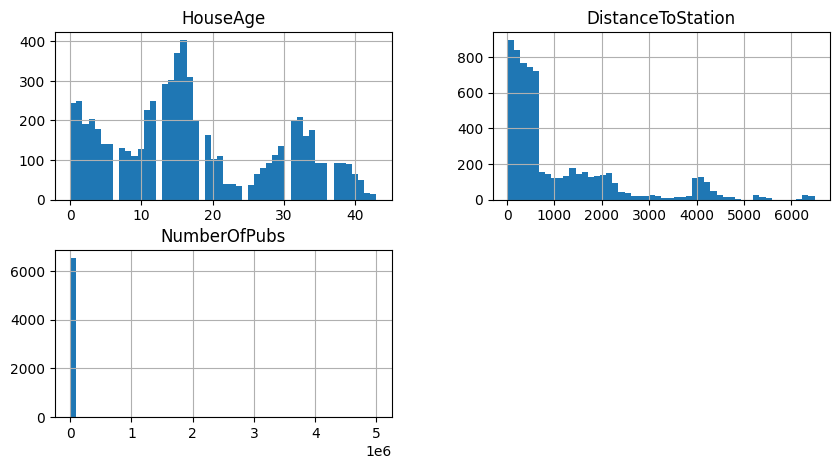

In [20]:
# histogrammen van numeric features
train.hist(figsize=(10,5), bins=50)
plt.show()

### Waarom komt House Price niet als numeric type?

In [21]:
# van string naar float, geeft error
# train['HousePrice'].astype(float)

In [22]:
# Filter de dataset op basis van HousePrice == '??'
train[train['HousePrice'] == '??']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8718,2020.08,16.0,122.432508,5.0,5213.0,??


In [23]:
# Drop de rows die gelijk zijn aan '??'
train = train[train['HousePrice'] != '??']

In [24]:
# Check
train[train['HousePrice'] == '??']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [25]:
# van string naar float 
train['HousePrice'] = train['HousePrice'].astype(float)

In [26]:
# check
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

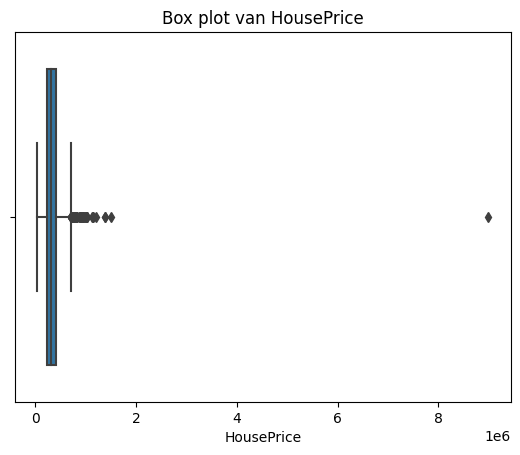

In [27]:
# Box plot voor HousePrice
plt.title('Box plot van HousePrice')
sns.boxplot(x=train['HousePrice'])
plt.show()

### Drop Outlier 

In [28]:
# De outlier vinden
train.sort_values('HousePrice', ascending=False).head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8445,2021.05,0.0,276.789752,9.0,5222.0,8989772.0
2749,2021.06,9.0,38.864337,1.0,5222.0,1504501.0
6066,2020.12,10.0,234.680008,1.0,5222.0,1374386.0
149,2020.09,9.0,228.930655,1.0,5222.0,1374277.0
9238,2019.11,10.0,169.424413,1.0,5222.0,1205920.0


In [29]:
train.sort_values('HousePrice', ascending=False).tail(10)

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8335,2019.12,31.0,6304.314375,1.0,5213.0,51069.0
4103,2019.03,17.0,4206.296909,0.0,5212.0,48141.0
2032,2019.1,17.0,4100.232310,0.0,5212.0,48131.0
821,2019.02,31.0,6432.041694,1.0,5212.0,47659.0
6150,2019.03,17.0,4076.782721,0.0,5212.0,42825.0
8103,2019.05,7.0,640.223538,10.0,5217.0,NaN
7673,nan,NaN,3830.892098,0.0,5217.0,NaN
32,2021.1,29.0,809.864711,8.0,5222.0,NaN
8112,2019.08,20.0,370.088151,NaN,nan,NaN


In [30]:
# Drop de 8445 row met de outlier 
train = train.drop(8445)

In [31]:
# Check
train.sort_values('HousePrice', ascending=False).head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
2749,2021.06,9.0,38.864337,1.0,5222.0,1504501.0
6066,2020.12,10.0,234.680008,1.0,5222.0,1374386.0
149,2020.09,9.0,228.930655,1.0,5222.0,1374277.0
9238,2019.11,10.0,169.424413,1.0,5222.0,1205920.0
5091,2020.05,10.0,295.072723,1.0,5614.0,1151940.0


### Wat is er met pubs aan de hand

In [32]:
# Data sorteren obv NumberOfPubs
train.sort_values('NumberOfPubs', ascending=False).head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
13,2019.05,8.0,273.264542,4999999.0,5213.0,356012.0
6662,2021.07,34.0,243.192562,10.0,5217.0,415434.0
4422,2019.02,34.0,63.249269,10.0,5212.0,271698.0
8337,2020.03,30.0,231.602328,10.0,5212.0,295032.0
8081,2021.11,7.0,497.646844,10.0,5222.0,726336.0


In [33]:
train.sort_values('NumberOfPubs', ascending=False).tail()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
412,2020.05,17.0,1193.293474,0.0,5217.0,188231.0
4651,2020.01,4.0,2505.509457,0.0,5217.0,211115.0
606,2021.05,16.0,3368.601302,0.0,5222.0,334279.0
2416,2019.06,NaN,NaN,NaN,5222.0,268172.0
8112,2019.08,20.0,370.088151,NaN,nan,NaN


In [34]:
# droppen van row 13 met de outlier
train = train.drop(13)

In [35]:
# check
train.sort_values('NumberOfPubs', ascending=False).head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8221,2020.04,22.0,547.624491,10.0,5614.0,455468.0
6219,2021.1,33.0,289.738467,10.0,5212.0,358547.0
5053,2020.07,23.0,526.260582,10.0,5213.0,304294.0
9032,2020.1,19.0,115.122324,10.0,5222.0,550060.0
2261,2021.07,30.0,423.424026,10.0,5213.0,309874.0


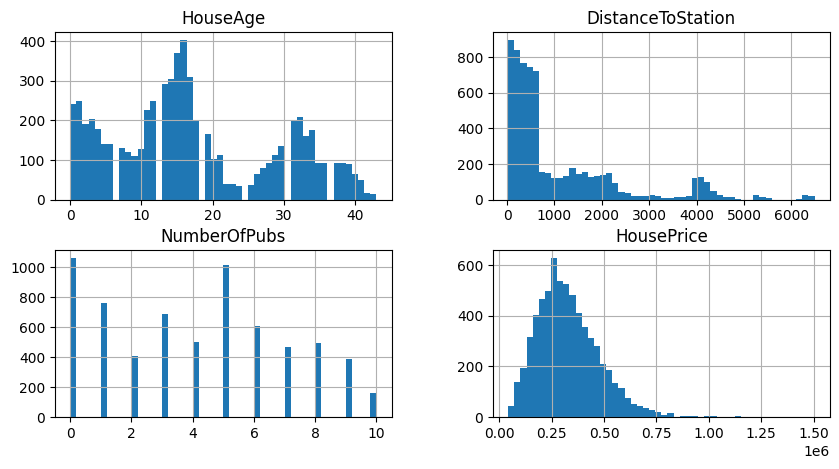

In [36]:
# histogrammen van numeric features
train.hist(figsize=(10,5), bins=50)
plt.show()

## Analyse Categorical Variables

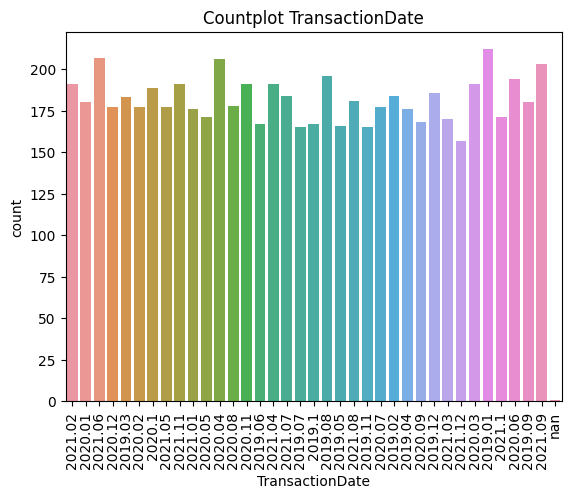

In [37]:
# Countplot van TransactionDate
plt.title('Countplot TransactionDate')
plt.xticks(rotation=90)
sns.countplot(
    data=train,
    x='TransactionDate'
)
plt.show()

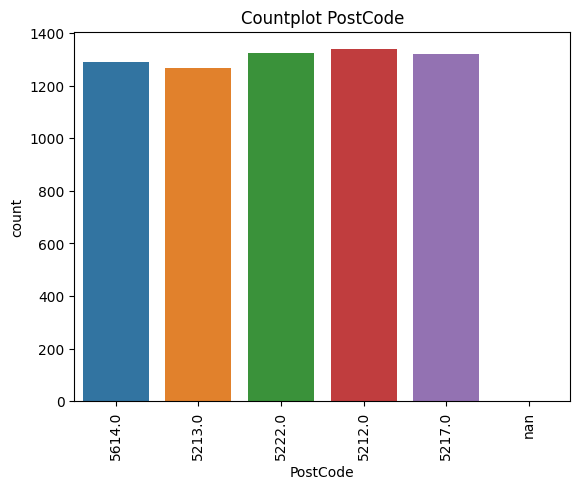

In [38]:
# Countplot van PostCode
plt.title('Countplot PostCode')
plt.xticks(rotation=90)
sns.countplot(
    data=train,
    x='PostCode'
)
plt.show()

## Analyse Relationships Numeric/Numeric

In [39]:
# Pearson's Correlation Berekenen
train.select_dtypes(exclude='object').corr()

,HouseAge,DistanceToStation,NumberOfPubs,HousePrice
HouseAge,1.000000,0.034074,0.044189,-0.156693
DistanceToStation,0.034074,1.000000,-0.586704,-0.539859
NumberOfPubs,0.044189,-0.586704,1.000000,0.452309
HousePrice,-0.156693,-0.539859,0.452309,1.000000


NumberOfPubs en DistanceToStation kan zorgen voor problemen omdat ze met elkaar redelijk sterk gecorreleerd zijn.

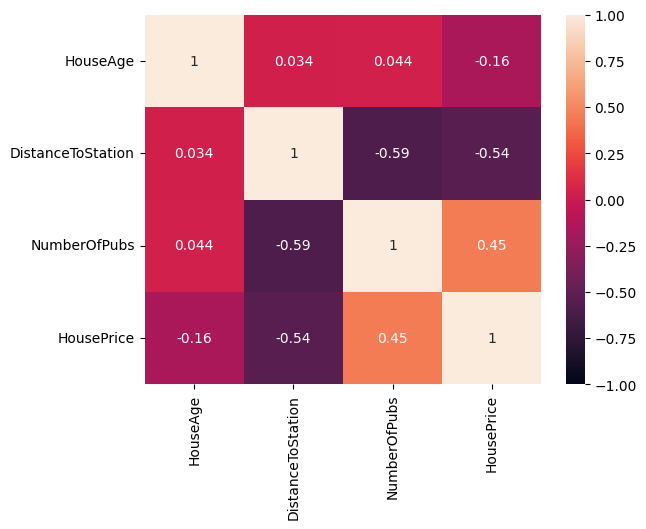

In [40]:
# Correlation heatmap
sns.heatmap(
    train.select_dtypes(exclude='object').corr(),
    vmin=-1,
    vmax=1,
    annot=True
)
plt.show()

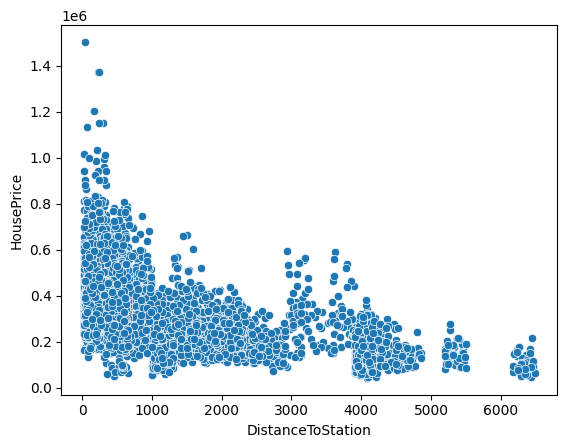

In [41]:
# Scatterplot creëeren
sns.scatterplot(
    data=train,
    x='DistanceToStation',
    y='HousePrice'
)
plt.show()

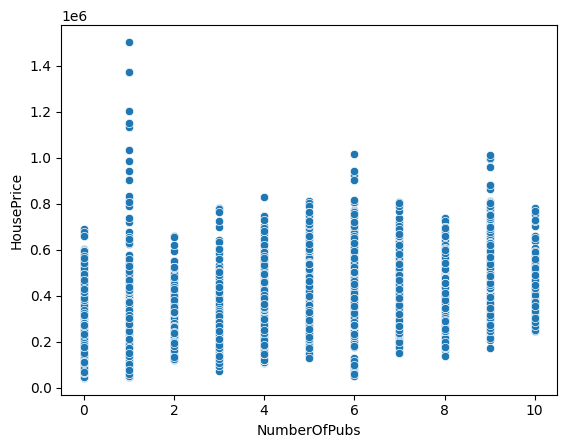

In [42]:
# Scatterplot creëeren
sns.scatterplot(
    data=train,
    x='NumberOfPubs',
    y='HousePrice'
)
plt.show()

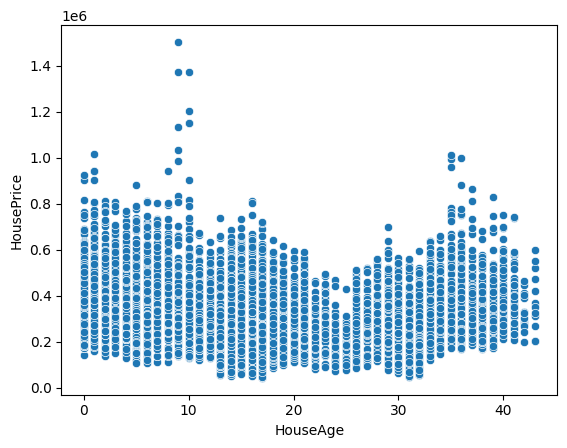

In [43]:
# Scatterplot creëeren
sns.scatterplot(
    data=train,
    x='HouseAge',
    y='HousePrice'
)
plt.show()

## Analyse Relationships Cat/Num

### Is de PostCode in verband met de HousePrice

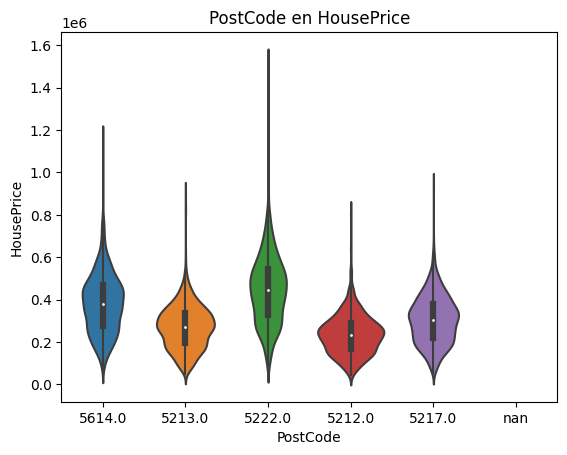

In [44]:
# Violinplot creëeren
plt.title('PostCode en HousePrice')
sns.violinplot(
    data=train,
    x='PostCode',
    y='HousePrice'
)
plt.show()

### Is er een verband tussen de Date en HousePrice?

In [45]:
# Check voor nulls
train[train['TransactionDate'].isnull()]

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [46]:
# Check of string aanwezig is in de kolom
train[train['TransactionDate'] == 'nan']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
7673,nan,NaN,3830.892098,0.0,5217.0,NaN


In [47]:
# Drop rijen met nan HousePrice
# ~ staat voor tegenovergesteld, dus alles wat niet null is
train = train[~train['HousePrice'].isnull()]

In [48]:
# Check TransactionDate
train[train['TransactionDate'] == 'nan']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [49]:
#  Check HousePrice
train[train['HousePrice'].isnull()]

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [50]:
# Toepassen van string transformation op TransactionDate
train['YearSold'] = train['TransactionDate'].apply(lambda x: x[:4]).astype(int)
train['MonthSold'] = train['TransactionDate'].apply(lambda x: x[5:]).astype(int)

In [51]:
train.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice,YearSold,MonthSold
ID,,,,,,,,
8450,2021.02,34.0,460.994365,8.0,5614.0,460286.0,2021,2
5758,2020.01,17.0,614.851833,3.0,5213.0,253332.0,2020,1
4030,2021.06,34.0,285.892687,9.0,5614.0,486532.0,2021,6
8447,2020.12,0.0,195.213314,6.0,5222.0,595168.0,2020,12
4370,2019.03,34.0,124.082230,8.0,5212.0,250495.0,2019,3


In [52]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
YearSold               int32
MonthSold              int32
dtype: object

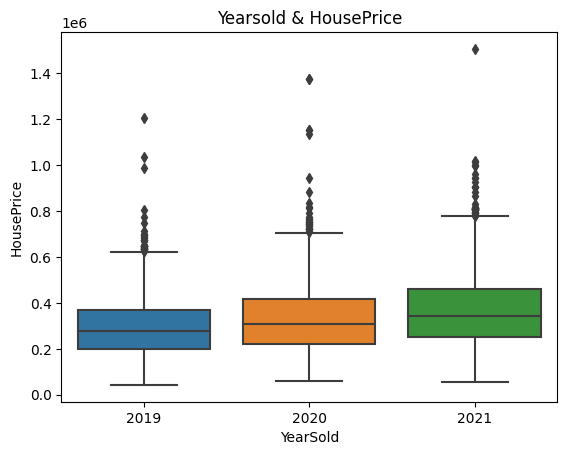

In [53]:
# Boxplot creëeren
plt.title('Yearsold & HousePrice')
sns.boxplot(
    data=train,
    x='YearSold',
    y='HousePrice'
)
plt.show()

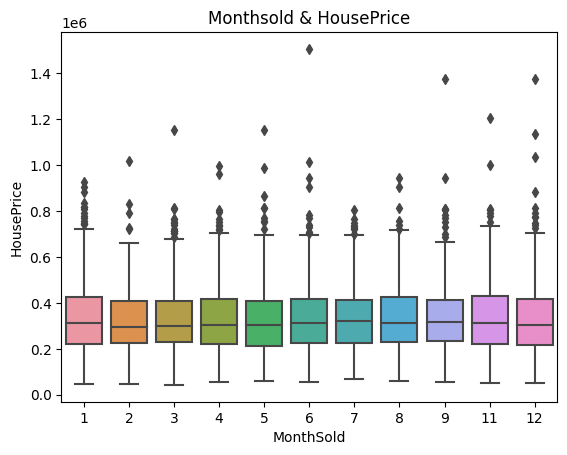

In [54]:
# Boxplot creëeren
plt.title('Monthsold & HousePrice')
sns.boxplot(
    data=train,
    x='MonthSold',
    y='HousePrice'
)
plt.show()

In [55]:
train = train.drop(['YearSold', 'MonthSold'], axis=1)

# 4. Data Preprocessing

## Bouwen van Preprocessing Function

In [56]:
# importeren
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [57]:
class Preprocessor(BaseEstimator, TransformerMixin): 
    # Train de custom preprocessors 
    def fit(self, X, y=None): 
        
        # Creëer een fit simple imputer
        self.imputer = SimpleImputer()
        self.imputer.fit(X[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        
        # Creëer een fit simple imputer
        self.scaler = StandardScaler()
        self.scaler.fit(X[['HouseAge', 'DistanceToStation', 'NumberOfPubs']]) 
        
        # Creëeren van fit One Hot Encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[['PostCode']])
        
        return self 
        
        
    # Creëeren van fit One Hot Encoder
    def transform(self, X): 
        
        # Apply simple imputer 
        imputed_cols = self.imputer.transform(X[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        onehot_cols = self.onehot.transform(X[['PostCode']])
        
        # Kopieer de df 
        transformed_df = X.copy()
        
        # Voeg jaar en maand transformatie toe 
        transformed_df['Year'] = transformed_df['TransactionDate'].apply(lambda x: x[:4]).astype(int)
        transformed_df['Month'] = transformed_df['TransactionDate'].apply(lambda x: x[5:]).astype(int)
        transformed_df = transformed_df.drop('TransactionDate', axis=1)
        
        # Apply de getransfromeerde kolommen
        transformed_df[['HouseAge', 'DistanceToStation', 'NumberOfPubs']] = imputed_cols
        transformed_df[['HouseAge', 'DistanceToStation', 'NumberOfPubs']] = self.scaler.transform(transformed_df[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        
        # Drop bestaande Post Code kolom
        transformed_df = transformed_df.drop('PostCode', axis=1) 
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

## Preview Preprocessed Data

In [58]:
preproc = Preprocessor()

In [59]:
preproc.fit(train)

Preprocessor()

In [60]:
preprocessed_df = preproc.transform(train)
preprocessed_df.head()

,HouseAge,DistanceToStation,NumberOfPubs,HousePrice,Year,Month,PostCode_5212.0,PostCode_5213.0,PostCode_5217.0,PostCode_5222.0,PostCode_5614.0
ID,,,,,,,,,,,
8450,1.449005,-0.496716,1.328375,460286.0,2021,2,0,0,0,0,1
5758,-0.033105,-0.375573,-0.363196,253332.0,2020,1,0,1,0,0,0
4030,1.449005,-0.634586,1.666689,486532.0,2021,6,0,0,0,0,1
8447,-1.515216,-0.705984,0.651746,595168.0,2020,12,0,0,0,1,0
4370,1.449005,-0.761991,1.328375,250495.0,2019,3,1,0,0,0,0


In [61]:
preprocessed_df.dtypes

HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
HousePrice           float64
Year                   int32
Month                  int32
PostCode_5212.0        int32
PostCode_5213.0        int32
PostCode_5217.0        int32
PostCode_5222.0        int32
PostCode_5614.0        int32
dtype: object

In [62]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6541 entries, 8450 to 8915
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HouseAge           6541 non-null   float64
 1   DistanceToStation  6541 non-null   float64
 2   NumberOfPubs       6541 non-null   float64
 3   HousePrice         6541 non-null   float64
 4   Year               6541 non-null   int32  
 5   Month              6541 non-null   int32  
 6   PostCode_5212.0    6541 non-null   int32  
 7   PostCode_5213.0    6541 non-null   int32  
 8   PostCode_5217.0    6541 non-null   int32  
 9   PostCode_5222.0    6541 non-null   int32  
 10  PostCode_5614.0    6541 non-null   int32  
dtypes: float64(4), int32(7)
memory usage: 434.4 KB


## Create X and y values

In [63]:
X_train = train.drop('HousePrice', axis=1)
y_train = train['HousePrice']

# 5. Modelling

## Import ML Dependencies

In [64]:
# importing
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

## Creëer Pipelines

In [65]:
# pipeline aanmaken
pipelines = {
    'ridge': make_pipeline(Preprocessor(), Ridge()), 
    'rf': make_pipeline(Preprocessor(), RandomForestRegressor()), 
    'gb': make_pipeline(Preprocessor(), GradientBoostingRegressor()), 
    'xg': make_pipeline(Preprocessor(), XGBRegressor()), 
}

## Create Tuning Grids

In [66]:
# Tuning grid
grid = {
    'ridge':{'ridge__alpha':[0.05, 0.25, 0.5, 1.0]}, 
    'rf':{
        'randomforestregressor__n_estimators':[100,200,300], 
        'randomforestregressor__max_depth':[5,6,7,None]
    },
    'gb':{
        'gradientboostingregressor__n_estimators':[100,200,300], 
        'gradientboostingregressor__max_depth':[5,6,7, None]
    },
    'xg':{
       'xgbregressor__n_estimators':[100,200,300], 
       'xgbregressor__max_depth':[5,6,7,None]
    }
}

## Train Models en Perform HPO

In [67]:
# importeren
from sklearn.model_selection import GridSearchCV

In [68]:
fit_models = {}
fit_models = {}
for algo, pipeline in pipelines.items(): 
    try: 
        print(f'Fitting: {algo}')
        model = GridSearchCV(pipeline, grid[algo], n_jobs=-1, cv=10, scoring='r2')
        model.fit(X_train, y_train) 
        fit_models[algo] = model 
    except Exception as e: 
        print(f'Model {algo} had an error: {e}')

Fitting: ridge
Fitting: rf
Fitting: gb
Fitting: xg


# 6. Evaluate Models

## Import Evaluation Metrics

In [69]:
# importeren
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Preprocess Test Set voor Predictions

### Kijken naar Nulls

In [70]:
# Kijken of er nulls in de testdataset zit
test.isnull().sum()

TransactionDate      1
HouseAge             1
DistanceToStation    0
NumberOfPubs         0
PostCode             0
HousePrice           2
dtype: int64

In [71]:
# Drop de nulls van HousePrice
test = test[~test.HousePrice.isnull()]

In [72]:
# Check
test.isnull().sum()

TransactionDate      0
HouseAge             1
DistanceToStation    0
NumberOfPubs         0
PostCode             0
HousePrice           0
dtype: int64

### Check datatypes

In [73]:
# Kijken naar de datatypes
test.dtypes

TransactionDate      float64
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode             float64
HousePrice            object
dtype: object

In [74]:
# preprocessings stappen
test = test[test['HousePrice']!='??']
test['HousePrice'] = test.HousePrice.astype(float)
test['TransactionDate'] = test.TransactionDate.astype(str)
test['PostCode'] = test.PostCode.astype(str)

In [75]:
# Check
test.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

### Create X_test and y_test 

In [76]:
# Maak X en y sets
X_test = test.drop('HousePrice', axis=1)
y_test = test['HousePrice']

In [77]:
# check
X_test.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode
ID,,,,,
7857,2021.11,0.0,267.000535,6.0,5222.0
1641,2021.04,12.0,500.080510,5.0,5212.0
3620,2019.07,14.0,4024.663391,0.0,5614.0
2820,2020.09,18.0,568.954185,4.0,5614.0
1572,2020.07,11.0,44.210016,1.0,5614.0


In [78]:
y_test.head()

ID
7857    919497.0
1641    283680.0
3620    135818.0
2820    468742.0
1572    311065.0
Name: HousePrice, dtype: float64

In [79]:
print(X_test.shape)
print(y_test.shape)

(2803, 5)
(2803,)


## Calculate Regression Metrics

In [80]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    r2 = r2_score(y_test, yhat)
    mae = mean_absolute_error(y_test, yhat)
    print(f'{algo}- R2 Score: {r2}, MAE Score: {mae}')

ridge- R2 Score: 0.6691443155811747, MAE Score: 62578.08779739755
rf- R2 Score: 0.8215281135435719, MAE Score: 44268.50306457367
gb- R2 Score: 0.8631056877348575, MAE Score: 38669.23319796218
xg- R2 Score: 0.853617617693814, MAE Score: 39618.537530937836


## Make Predictions

In [81]:
# beste model 
model = fit_models['gb']

In [82]:
# Voorspel X_test
yhat = model.predict(X_test)

In [83]:
# Evaluation datafram
results_df = y_test.to_frame()
results_df['yhat'] = yhat
results_df['delta'] = results_df.HousePrice.astype(float) - results_df.yhat

In [84]:
results_df.head(10)

,HousePrice,yhat,delta
ID,,,
7857,919497.0,660072.297268,259424.702732
1641,283680.0,289177.792976,-5497.792976
3620,135818.0,166619.494653,-30801.494653
2820,468742.0,398384.284510,70357.715490
1572,311065.0,389518.489960,-78453.489960
202,228740.0,198964.593398,29775.406602
8169,260611.0,294784.660229,-34173.660229
6212,199843.0,210704.128943,-10861.128943
6754,273619.0,260715.373646,12903.626354


In [85]:
# Evaluation DF opslaan naar CSV
results_df.to_csv('results.csv')

## Explain model

### Calculate Feature Importance

In [86]:
# Beste estimator
ensemble = model.best_estimator_['gradientboostingregressor']

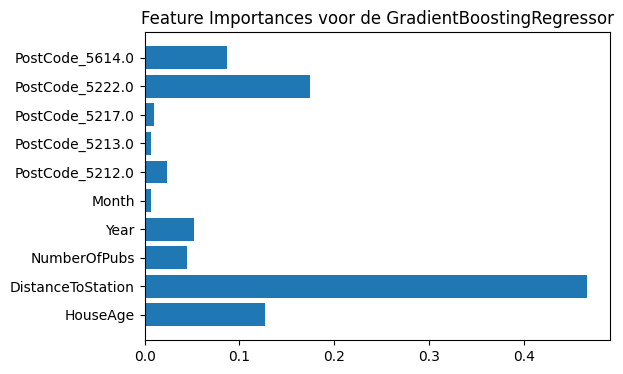

In [87]:
# Feature importance in procenten

plt.figure(figsize=(6,4))
plt.title('Feature Importances voor de GradientBoostingRegressor')
plt.barh(ensemble.feature_names_in_, ensemble.feature_importances_)
plt.show()

### Calculate Feature Importance for All Models

In [88]:
# importeren
import numpy as np

In [89]:
# bereken feature importances
feature_importances = {}
for algo, pipeline in fit_models.items(): 
    if algo == 'ridge': 
        coef_ = pipeline.best_estimator_[1].coef_
        feature_importances[algo] = np.square(coef_) / np.sum(np.square(coef_))
    else: 
        feature_importances[algo] = pipeline.best_estimator_[1].feature_importances_

In [90]:
# check
feature_importances

{'ridge': array([1.64842453e-02, 1.01874497e-01, 3.10969377e-02, 3.86862977e-02,
        5.94596526e-06, 2.25704876e-01, 9.47271060e-02, 1.69412578e-02,
        3.92285970e-01, 8.21928660e-02]),
 'rf': array([0.13633334, 0.44660923, 0.05559191, 0.0512363 , 0.0343812 ,
        0.00898443, 0.0028031 , 0.01170055, 0.16593532, 0.08642462]),
 'gb': array([0.12745454, 0.46735026, 0.04520097, 0.05171377, 0.00638425,
        0.02391813, 0.00646687, 0.00966443, 0.17488726, 0.08695952]),
 'xg': array([0.03207528, 0.07127062, 0.02292063, 0.05411822, 0.00475283,
        0.09275293, 0.02268689, 0.04478648, 0.41193107, 0.24270506],
       dtype=float32)}

In [91]:
# feature importances naar DataFrame
importance_df = pd.DataFrame(feature_importances, index=ensemble.feature_names_in_)
importance_df

,ridge,rf,gb,xg
HouseAge,0.016484,0.136333,0.127455,0.032075
DistanceToStation,0.101874,0.446609,0.467350,0.071271
NumberOfPubs,0.031097,0.055592,0.045201,0.022921
Year,0.038686,0.051236,0.051714,0.054118
Month,0.000006,0.034381,0.006384,0.004753
PostCode_5212.0,0.225705,0.008984,0.023918,0.092753
PostCode_5213.0,0.094727,0.002803,0.006467,0.022687
PostCode_5217.0,0.016941,0.011701,0.009664,0.044786
PostCode_5222.0,0.392286,0.165935,0.174887,0.411931
PostCode_5614.0,0.082193,0.086425,0.086960,0.242705


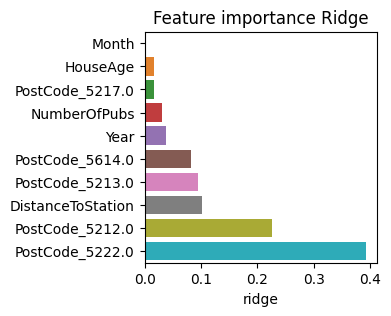

In [92]:
# plot Feature importance Ridge
plt.figure(figsize=(3,3))
plt.title('Feature importance Ridge')
model_name = 'ridge'
sorted_imp = importance_df.sort_values(model_name)
sns.barplot(x = model_name, y = sorted_imp.index, data=sorted_imp)
plt.show()

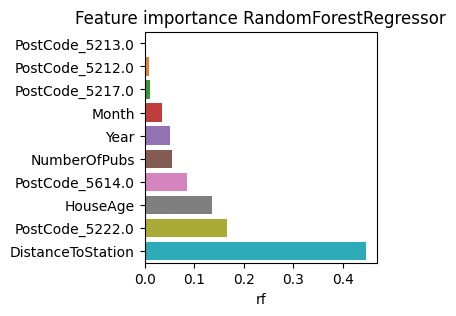

In [93]:
# plot Feature importance RandomForestRegressor
plt.figure(figsize=(3,3))
plt.title('Feature importance RandomForestRegressor')
model_name = 'rf'
sorted_imp = importance_df.sort_values(model_name)
sns.barplot(x = model_name, y = sorted_imp.index, data=sorted_imp)
plt.show()

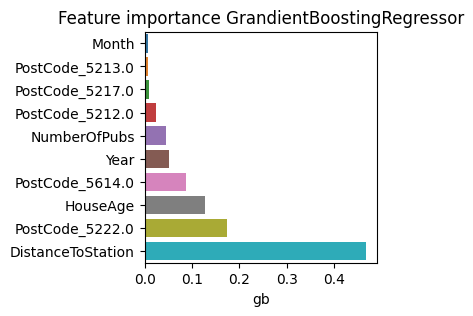

In [94]:
# plot Feature importance GrandientBoostingRegressor
plt.figure(figsize=(3,3))
plt.title('Feature importance GrandientBoostingRegressor')
model_name = 'gb'
sorted_imp = importance_df.sort_values(model_name)
sns.barplot(x = model_name, y = sorted_imp.index, data=sorted_imp)
plt.show()

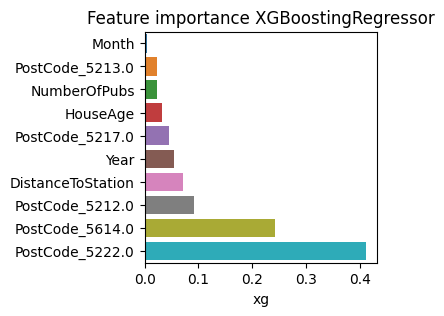

In [95]:
# plot Feature importance XGBoostingRegressor
plt.figure(figsize=(3,3))
plt.title('Feature importance XGBoostingRegressor')
model_name = 'xg'
sorted_imp = importance_df.sort_values(model_name)
sns.barplot(x = model_name, y = sorted_imp.index, data=sorted_imp)
plt.show()

### Plot Trees

In [96]:
# installeer graphviz
!pip install graphviz

     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [97]:
# importeren 
from sklearn.tree import plot_tree
import xgboost as xgb
from matplotlib.pylab import rcParams

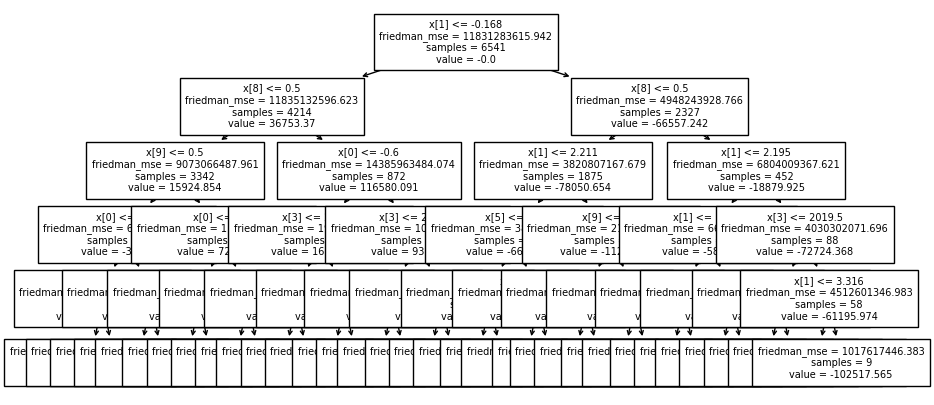

In [98]:
# Plot tree voor gradient boosted model
plt.figure(figsize=(10,5))
plot_tree(ensemble.estimators_[5,0], fontsize=7)
plt.show()

# 7. Save model

In [101]:
# importen
import dill

In [103]:
model = fit_models['gb']

In [105]:
# Save model met dill
with open('gb.pkl', 'wb') as f:
    dill.dump(model, f)

In [109]:
# reload check
with open('gb.pkl', 'rb') as f:
    reloaded_model = dill.load(f)

reloaded_model.predict(X_test)

array([660072.29726806, 289177.79297644, 166619.49465334, ...,
       392935.05936691, 737461.9967578 , 399972.54185107])

In [110]:
X_test.loc[0].to_json()

'{"TransactionDate":"2020.12","HouseAge":17.0,"DistanceToStation":467.6447748,"NumberOfPubs":4.0,"PostCode":"5222.0"}'